<a href="https://colab.research.google.com/github/shuyaguan/0826/blob/main/AIFinal_Shuya_Guan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparing binary classification dataset...
Binary dataset created: 200 graffiti images, 200 non-graffiti images
Configuring data generators...
Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Creating lightweight model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.75_160            │ (None, 5, 5, 1280)     │     1,382,064 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,464,113 (5.59 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 1,382,064 (5.27 MB)

Starting model training...
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5989 - loss: 0.6215 - val_accuracy: 0.5500 - val_loss: 0.9687
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 869ms/step - accuracy: 0.8919 - loss: 0.3011 - val_accuracy: 0.6750 - val_loss: 0.7616
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 873ms/step - accuracy: 0.8801 - loss: 0.2805 - val_accuracy: 0.6125 - val_loss: 0.9438
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 878ms/step - accuracy: 0.8876 - loss: 0.2613 - val_accuracy: 0.7000 - val_loss: 0.7881
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 867ms/step - accuracy: 0.9218 - loss: 0.1883 - val_accuracy: 0.6375 - val_loss: 0.8327


Model saved to: /content/drive/My Drive/graffiti_binary_classifier.h5


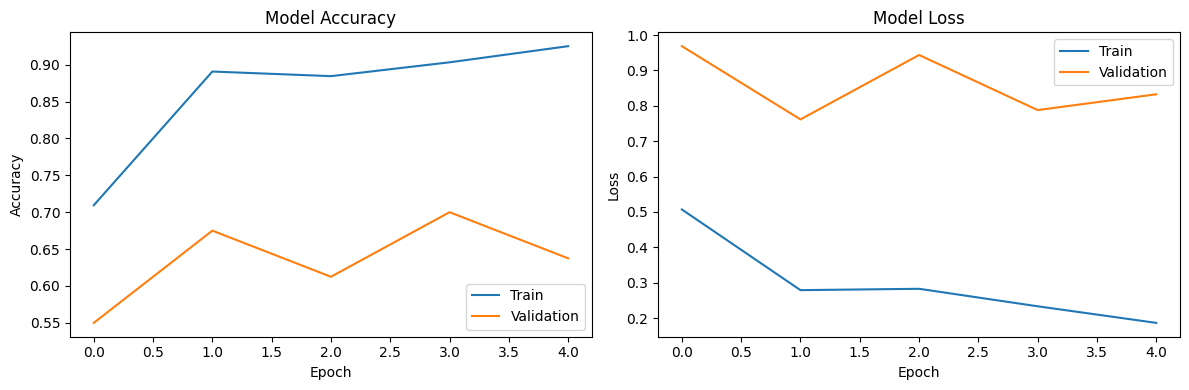

Training and evaluation complete!


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt

# Set paths
dataset_path = "/content/drive/My Drive/Graffiti_Streetview"

# Create binary classification dataset structure
binary_dataset_path = "/content/binary_graffiti_dataset"
os.makedirs(f"{binary_dataset_path}/graffiti", exist_ok=True)
os.makedirs(f"{binary_dataset_path}/no_graffiti", exist_ok=True)

# Prepare binary dataset (create symbolic links to save storage space and time)
def prepare_binary_dataset():
    print("Preparing binary classification dataset...")

    # To save time, we use a subset of samples
    # Copy samples from graffiti
    graffiti_src = os.path.join(dataset_path, "graffiti")
    graffiti_files = os.listdir(graffiti_src)[:100]  # Max 100 files
    for file in graffiti_files:
        src_path = os.path.join(graffiti_src, file)
        dst_path = os.path.join(binary_dataset_path, "graffiti", f"g_{file}")
        try:
            os.symlink(src_path, dst_path)
        except:
            pass

    # Copy samples from graffiti_train
    graffiti_train_src = os.path.join(dataset_path, "graffiti_train")
    graffiti_train_files = os.listdir(graffiti_train_src)[:100]  # Max 100 files
    for file in graffiti_train_files:
        src_path = os.path.join(graffiti_train_src, file)
        dst_path = os.path.join(binary_dataset_path, "graffiti", f"gt_{file}")
        try:
            os.symlink(src_path, dst_path)
        except:
            pass

    # Copy samples from no_graffiti
    no_graffiti_src = os.path.join(dataset_path, "no_graffiti")
    no_graffiti_files = os.listdir(no_graffiti_src)[:200]  # Max 200 files
    for file in no_graffiti_files:
        src_path = os.path.join(no_graffiti_src, file)
        dst_path = os.path.join(binary_dataset_path, "no_graffiti", file)
        try:
            os.symlink(src_path, dst_path)
        except:
            pass

    # Output file counts
    graffiti_count = len(os.listdir(os.path.join(binary_dataset_path, "graffiti")))
    no_graffiti_count = len(os.listdir(os.path.join(binary_dataset_path, "no_graffiti")))
    print(f"Binary dataset created: {graffiti_count} graffiti images, {no_graffiti_count} non-graffiti images")

    return binary_dataset_path

# Prepare data
def prepare_data(dataset_path, img_height=160, img_width=160, batch_size=64):
    print("Configuring data generators...")

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    # Create training data generator
    train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',  # Use binary classification
        subset='training'
    )

    validation_generator = validation_datagen.flow_from_directory(
        dataset_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',  # Use binary classification
        subset='validation'
    )

    return train_generator, validation_generator

# Create lightweight model
def create_model(img_height=160, img_width=160):
    print("Creating lightweight model...")

    # Use MobileNetV2 but choose smaller input size
    base_model = MobileNetV2(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights='imagenet',
        alpha=0.75  # Use smaller version of the model
    )

    # Freeze base model layers
    base_model.trainable = False

    # Build complete model
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),  # Reduce number of neurons
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    return model

# Train model
def train_model(model, train_generator, validation_generator, epochs=5):
    print("Starting model training...")

    # Add early stopping and model checkpoint callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            restore_best_weights=True
        )
    ]

    # Train model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    return history, model

# Visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Prepare binary dataset
    binary_path = prepare_binary_dataset()

    # Prepare data generators
    train_generator, validation_generator = prepare_data(binary_path)

    # Create model
    model = create_model()

    # Train model
    history, trained_model = train_model(model, train_generator, validation_generator)

    # Save model
    model_path = '/content/drive/My Drive/graffiti_binary_classifier.h5'
    trained_model.save(model_path)
    print(f"Model saved to: {model_path}")

    # Visualize training history
    plot_training_history(history)

    print("Training and evaluation complete!")

# Execute main function
if __name__ == "__main__":
    main()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import re
import pandas as pd

# 更新后的提取坐标函数
def extract_coordinates(filename):
    # 更新正则表达式以匹配带空格的格式 "Atlanta_ (33.735238, -84.40208).jpg"
    pattern = r'.*\(\s*([-0-9.]+)\s*,\s*([-0-9.]+)\s*\).*'
    match = re.search(pattern, filename)
    if match:
        lat = float(match.group(1))
        lon = float(match.group(2))
        return lat, lon
    return None, None

# 预测函数
def predict_graffiti(model, image_path, img_height=160, img_width=160):
    # 加载和预处理图像
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # 归一化
    img_array = np.expand_dims(img_array, axis=0)  # 添加批次维度

    # 进行预测
    prediction = model.predict(img_array, verbose=0)[0][0]

    return prediction

# 创建热力图函数
def create_graffiti_heatmap(predictions_df, output_file='graffiti_heatmap.html'):
    # 检查DataFrame是否为空
    if predictions_df.empty:
        print("无法创建热力图：没有有效的预测数据")
        return None

    # 创建以第一个位置为中心的基础地图
    center_lat = predictions_df['latitude'].median()
    center_lon = predictions_df['longitude'].median()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # 准备热力图数据
    heat_data = predictions_df[['latitude', 'longitude', 'graffiti_score']].values.tolist()

    # 添加热力图层
    HeatMap(heat_data, radius=15, blur=10, gradient={
        0.2: 'blue',
        0.4: 'lime',
        0.6: 'yellow',
        0.8: 'orange',
        1.0: 'red'
    }).add_to(m)

    # 为高涂鸦得分添加标记
    high_scores = predictions_df[predictions_df['graffiti_score'] > 0.7]
    for _, row in high_scores.iterrows():
        tooltip = f"得分: {row['graffiti_score']:.2f}<br>{row['filename']}"
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            tooltip=tooltip
        ).add_to(m)

    # 保存地图
    m.save(output_file)
    print(f"热力图已保存到 {output_file}")

    return m

# 分析街景图像目录的函数
def analyze_street_view_directory(model, directory, img_height=160, img_width=160):
    print(f"分析 {directory} 中的图像...")

    results = []
    valid_images = 0
    skipped_images = 0

    # 查找所有图像文件
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(directory, filename)

            # 从文件名中提取坐标
            lat, lon = extract_coordinates(filename)

            # 跳过没有坐标的图像
            if lat is None or lon is None:
                skipped_images += 1
                if skipped_images <= 10:  # 只显示前10个跳过的文件
                    print(f"跳过 {filename} - 无法提取坐标")
                continue

            # 预测涂鸦得分
            score = predict_graffiti(model, image_path, img_height, img_width)

            # 添加到结果
            results.append({
                'filename': filename,
                'latitude': lat,
                'longitude': lon,
                'graffiti_score': float(score)
            })
            valid_images += 1

    print(f"处理了 {valid_images} 个有效图像，跳过了 {skipped_images} 个图像")

    # 转换为DataFrame
    df = pd.DataFrame(results)

    if not df.empty:
        print(f"分析了 {len(df)} 张图像")
        print(f"平均涂鸦得分: {df['graffiti_score'].mean():.2f}")
        print(f"最高涂鸦得分: {df['graffiti_score'].max():.2f}")

        # 按涂鸦得分排序（最高的在前）
        df = df.sort_values('graffiti_score', ascending=False)

        # 显示得分最高的5个位置
        print("\n涂鸦得分最高的5个位置:")
        for i, row in df.head(5).iterrows():
            print(f"- {row['filename']}: 得分 {row['graffiti_score']:.2f}")
    else:
        print("没有找到可分析的有效图像")

    return df

# 可视化示例预测的函数
def visualize_examples(model, predictions_df, image_dir, num_examples=8):
    # 检查DataFrame是否为空
    if predictions_df.empty:
        print("无法可视化：没有有效的预测数据")
        return

    # 获取一些具有不同得分的示例
    if len(predictions_df) > num_examples:
        # 选择跨度分数范围的示例
        step = len(predictions_df) // num_examples
        examples = predictions_df.iloc[::step].head(num_examples)
    else:
        examples = predictions_df

    # 绘制示例
    fig, axes = plt.subplots(2, 4, figsize=(15, 8)) if num_examples >= 8 else plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, (_, row) in enumerate(examples.iterrows()):
        if i >= len(axes):
            break

        img_path = os.path.join(image_dir, row['filename'])
        img = load_img(img_path, target_size=(224, 224))

        axes[i].imshow(img)
        score = row['graffiti_score']
        color = 'green' if score > 0.5 else 'blue'
        axes[i].set_title(f"得分: {score:.2f}", color=color)
        axes[i].set_xlabel(f"纬度: {row['latitude']:.4f}, 经度: {row['longitude']:.4f}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/example_predictions.png')
    plt.show()

# 主函数加载模型并分析图像
def main():
    # 加载训练好的模型
    model_path = '/content/drive/My Drive/graffiti_binary_classifier.h5'
    print(f"从 {model_path} 加载模型")
    model = load_model(model_path)

    # 要分析的街景图像目录
    # 这应该是您的测试图像目录
    street_view_dir = '/content/drive/My Drive/Graffiti_Streetview/graffiti'  # 根据您的测试目录更改

    # 分析图像并获取预测
    predictions_df = analyze_street_view_directory(model, street_view_dir)

    # 如果DataFrame不为空，保存预测并创建热力图
    if not predictions_df.empty:
        # 保存预测到CSV
        csv_path = '/content/drive/My Drive/graffiti_predictions.csv'
        predictions_df.to_csv(csv_path, index=False)
        print(f"预测已保存到 {csv_path}")

        # 创建并保存热力图
        heatmap_path = '/content/drive/My Drive/graffiti_heatmap.html'
        create_graffiti_heatmap(predictions_df, heatmap_path)

        # 可视化一些示例
        visualize_examples(model, predictions_df, street_view_dir)
    else:
        print("没有可用的预测数据进行可视化或创建热力图")

    print("分析完成！")

# 执行主函数
if __name__ == "__main__":
    main()

从 /content/drive/My Drive/graffiti_binary_classifier.h5 加载模型


分析 /content/drive/My Drive/Graffiti_Streetview/graffiti 中的图像...
处理了 143 个有效图像，跳过了 0 个图像
分析了 143 张图像
平均涂鸦得分: 0.34
最高涂鸦得分: 0.98

涂鸦得分最高的5个位置:
- Jacksonvillef_ (30.32099, -81.656327).jpg: 得分 0.98
- Charlotte_ (35.212446, -80.820367).jpg: 得分 0.97
- Detroit_ (42.359381, -83.09293).jpg: 得分 0.96
- Portland_ (45.514046, -122.673914).jpg: 得分 0.96
- Chicago_ (41.826574, -87.690318).jpg: 得分 0.94
预测已保存到 /content/drive/My Drive/graffiti_predictions.csv


AttributeError: 'float' object has no attribute 'split'

In [ ]:
# 修改后的热力图创建函数
def create_graffiti_heatmap(predictions_df, output_file='graffiti_heatmap.html'):
    # 检查DataFrame是否为空
    if predictions_df.empty:
        print("无法创建热力图：没有有效的预测数据")
        return None

    # 创建以第一个位置为中心的基础地图
    center_lat = predictions_df['latitude'].median()
    center_lon = predictions_df['longitude'].median()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # 准备热力图数据 - 确保使用正确格式，每个点是[lat, lon, score]
    heat_data = []
    for _, row in predictions_df.iterrows():
        heat_data.append([row['latitude'], row['longitude'], row['graffiti_score']])

    # 添加热力图层
    HeatMap(
        heat_data,
        radius=15,
        blur=10,
        gradient={
            0.2: 'blue',
            0.4: 'lime',
            0.6: 'yellow',
            0.8: 'orange',
            1.0: 'red'
        }
    ).add_to(m)

    # 为高涂鸦得分添加标记
    high_scores = predictions_df[predictions_df['graffiti_score'] > 0.7]
    for _, row in high_scores.iterrows():
        tooltip = f"得分: {row['graffiti_score']:.2f}<br>{row['filename']}"
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            tooltip=tooltip
        ).add_to(m)

    # 保存地图
    m.save(output_file)
    print(f"热力图已保存到 {output_file}")

    return m